In [1]:
import numpy as np
from torch_geometric.datasets import Planetoid
from networkx import draw_spring
from torch_geometric.utils import to_networkx
from os.path import join
from random import sample
import matplotlib.pyplot as plt
from torch import device
from torch.optim import Adam
from torch.nn import Linear, CrossEntropyLoss, Module
from torch.nn.functional import softmax, dropout
from torch_geometric.nn import GCNConv
from warnings import filterwarnings

In [2]:
filterwarnings('ignore')

In [3]:
class Cora(Planetoid):

    def __int__(self, root, name):
        Planetoid.__init__(self, root=join(root, name), name=name)

    @property
    def _graph(self):
        return self[0]

    def graph(self):
        return self._graph

    def __str__(self):
        graph = self.graph()
        summary = f'    number of nodes: {graph.num_nodes} \n'\
                  f'    number of edges: {graph.num_edges} \n' \
                  f'    number of node features: {graph.num_node_features} \n' \
                  f'    number of node features: {graph.num_edge_features}'
        return 'Dataset Summary: \n' + summary

    def to_networkx(self, node_attributes='x', class_labels='y', n_samples=None):
        graph = self.graph()

        if n_samples is None:
            n_samples = graph.num_nodes

        labels = graph[class_labels].numpy()
        networkx_graph = to_networkx(graph, node_attrs=[node_attributes])

        if n_samples is not None:
            sampled_nodes = sample(networkx_graph.nodes, n_samples)
            networkx_graph = networkx_graph.subgraph(sampled_nodes)
            labels = labels[sampled_nodes]

        return networkx_graph, labels

    def plot_graph(self, node_attributes='x', class_labels='y', n_samples=None):
        graph, labels = self.to_networkx(node_attributes, class_labels, n_samples)
        plt.figure(figsize=(9, 7))
        draw_spring(graph, node_size=20, arrows=False, node_color=labels)
        plt.show()

In [4]:
class GCN(Module):
    def __init__(self, graph_dataset, hidden_channels):

        Module.__init__(self)

        self.first_convolutional_layer = GCNConv(graph_dataset.num_features, hidden_channels)
        self.second_convolutional_layer = GCNConv(hidden_channels, hidden_channels)
        self.output_layer = Linear(hidden_channels, len(np.unique(graph_dataset['y'])))

    def forward(self, input_vertices, edge_index):
        x = self.first_convolutional_layer(input_vertices, edge_index)
        x = x.relu()
        x = dropout(x, p=0.5, training=self.training)

        x = self.second_convolutional_layer(x, edge_index)
        x = x.relu()
        x = dropout(x, p=0.5, training=self.training)

        x = softmax(self.output_layer(x), dim=1)
        return x

In [5]:
def train():
      model.train()
      optimizer.zero_grad()
      output = model(graph_data['x'], graph_data['edge_index'])
      loss = criterion(output[graph_data['train_mask']],
                       graph_data['y'][graph_data['train_mask']])
      loss.backward()
      optimizer.step()
      return loss

In [6]:
from sklearn.metrics import accuracy_score

In [7]:
def test():
      model.eval()
      output = model(graph_data['x'], graph_data['edge_index'])
      predictions = output.argmax(dim=1)
      return accuracy_score(y_true=graph_data['y'][graph_data['test_mask']],
                           y_pred=predictions[graph_data['test_mask']])

In [8]:
cora_dataset = Cora(root='/tmp', name='Cora')
print(cora_dataset)

Dataset Summary: 
    number of nodes: 2708 
    number of edges: 10556 
    number of node features: 1433 
    number of node features: 0


In [9]:
graph_data = cora_dataset.graph()

In [10]:
model = GCN(graph_dataset=graph_data, hidden_channels=28)
device = device("cpu")
model = model.to(device)
graph_data = graph_data.to(device)

In [11]:
learning_rate = 0.01
decay = 0.00001
optimizer = Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)
criterion = CrossEntropyLoss()

In [12]:
losses = []
for epoch in range(0, 1001):
    epoch_loss = train()
    losses.append(epoch_loss)
    if epoch % 50 == 0:
      print(f'Epoch: {epoch}, Loss: {epoch_loss}')

Epoch: 0, Loss: 1.9460961818695068
Epoch: 50, Loss: 1.2002612352371216
Epoch: 100, Loss: 1.187220573425293
Epoch: 150, Loss: 1.1747851371765137
Epoch: 200, Loss: 1.1857209205627441
Epoch: 250, Loss: 1.1873095035552979
Epoch: 300, Loss: 1.1757889986038208
Epoch: 350, Loss: 1.1743407249450684
Epoch: 400, Loss: 1.1856908798217773
Epoch: 450, Loss: 1.1735093593597412
Epoch: 500, Loss: 1.1748279333114624
Epoch: 550, Loss: 1.1808619499206543
Epoch: 600, Loss: 1.1749032735824585
Epoch: 650, Loss: 1.1732810735702515
Epoch: 700, Loss: 1.1746610403060913
Epoch: 750, Loss: 1.174048662185669
Epoch: 800, Loss: 1.1799410581588745
Epoch: 850, Loss: 1.1781419515609741
Epoch: 900, Loss: 1.1682841777801514
Epoch: 950, Loss: 1.1715611219406128
Epoch: 1000, Loss: 1.1786999702453613


In [13]:
print(f'Accuracy score: {test()}')

Accuracy score: 0.762


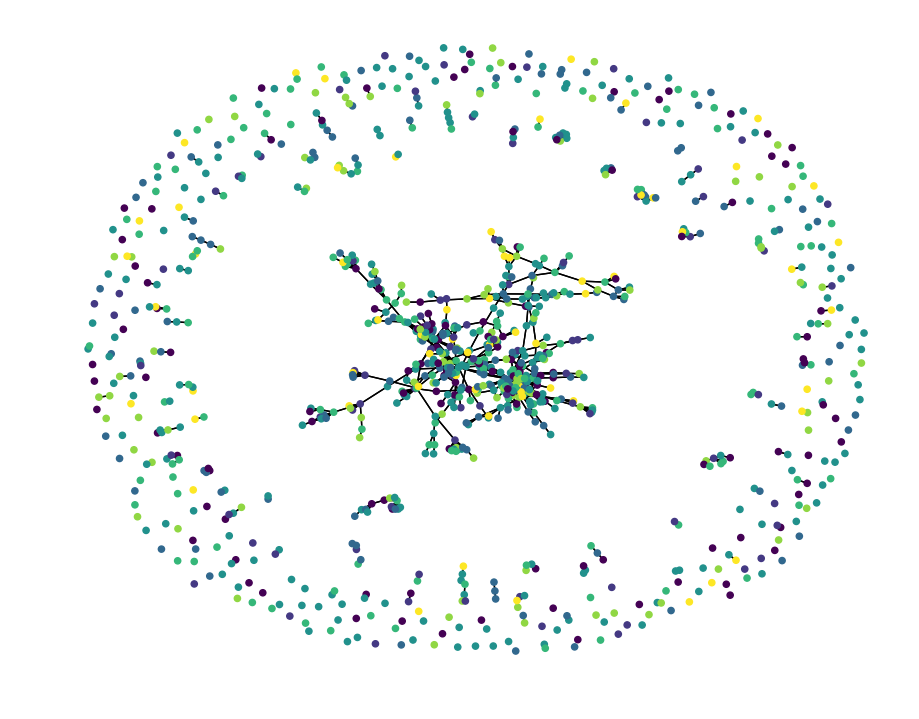

In [14]:
cora_dataset.plot_graph(n_samples=1000)